In [1]:
import numpy as np
import pandas as pd
from keras.layers import (Input, Embedding, Conv1D, Activation, GlobalMaxPool1D, BatchNormalization,
                          Concatenate, CuDNNLSTM, Flatten, Dropout, Dense)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical, Sequence, plot_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
news = pd.read_pickle('../input/stopwords-removal-and-lemmatization/data.pkl')
news = shuffle(news, random_state=29)
news.head()

,text,category
107620,feel meaningful feel immortal,WORLDPOST
195600,watch <NUM> YouTube Videos week look popular Y...,TECH
188153,Kobe Bryant Divorce : report reconciliation Af...,DIVORCE
130822,walk Tightrope Life struggle proper use time a...,WELLNESS
109816,<NUM> piece advice save parent ' Sanity Parent...,PARENTS


In [3]:
news['category'] = news['category'].apply(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
labels = list(set(news['category']))
news['category'] = news['category'].apply(labels.index)
X_train, X_test, y_train, y_test = train_test_split(news['text'], news['category'], test_size=0.3, random_state=4)
X_holdout, X_test, y_holdout, y_test = train_test_split(X_test, y_test, test_size=0.66, random_state=98)
y_train, y_test, y_holdout = list(y_train), list(y_test), list(y_holdout)

In [4]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(news['text'])
X_train = tokenizer.texts_to_sequences(X_train)
X_holdout = tokenizer.texts_to_sequences(X_holdout)
X_test = tokenizer.texts_to_sequences(X_test)

In [5]:
def get_embed_mat(EMBEDDING_FILE):
    embeddings_index = {}
    with open(EMBEDDING_FILE, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
    
    word_index = tokenizer.word_index
    num_words = len(word_index) + 1
    all_embs = np.stack(embeddings_index.values())
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= num_words:
            break
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return num_words, embedding_matrix

EMBEDDING_FILE = '../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
embed_dim = 200
num_words, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


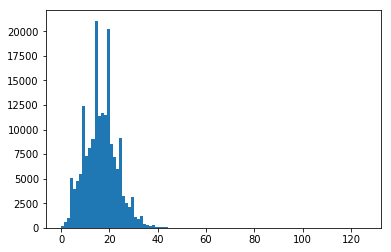

In [6]:
plot = plt.hist([len(x) for x in X_train + X_test], bins=100)

In [7]:
max_length = 50
print('Sequence length:', max_length)

Sequence length: 50


**CNN - Static**

In [8]:
num_classes = len(labels)
layers = []
filters = [2, 3, 5]

sequence_input1 = Input(shape=(max_length, ), dtype='int32')
embedding_layer_static1 = Embedding(num_words, embed_dim, embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length, trainable=False)(sequence_input1)

for sz in filters:
    conv_layer1 = Conv1D(filters=256, kernel_size=sz)(embedding_layer_static1)
    batchnorm_layer1 = BatchNormalization()(conv_layer1)
    act_layer1 = Activation('relu')(batchnorm_layer1)
    pool_layer1 = GlobalMaxPool1D()(act_layer1)
    layers.append(pool_layer1)

merged1 = Concatenate(axis=1)(layers)

drop1 = Dropout(0.5)(merged1)
dense1 = Dense(512, activation='relu')(drop1)
out1 = Dense(num_classes, activation='softmax')(dense1)

cnn_static = Model(sequence_input1, out1)
cnn_static.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 200)      16268200    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 49, 256)      102656      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)    

In [9]:
def top_3_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

class dataseq(Sequence):
    def __init__(self, X, y, batch_size, padding='post'):
        self.x, self.y = X, y
        self.batch_size = batch_size
        self.m = len(self.y)
        self.padding = padding

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:min((idx + 1) * self.batch_size, self.m)]
        batch_y = self.y[idx * self.batch_size:min((idx + 1) * self.batch_size, self.m)]

        return pad_sequences(batch_x, maxlen=max_length, truncating='post', padding=self.padding), to_categorical(
            batch_y, num_classes=num_classes)

cnn_static.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', top_3_acc])

batch_size = 128
cnn_static_history = cnn_static.fit_generator(dataseq(X_train, y_train, batch_size), epochs=15, verbose=2,
                              validation_data = dataseq(X_holdout, y_holdout, batch_size), shuffle=True)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/15
 - 18s - loss: 2.2032 - acc: 0.4386 - top_3_acc: 0.6494 - val_loss: 1.5834 - val_acc: 0.5590 - val_top_3_acc: 0.7878
Epoch 2/15
 - 12s - loss: 1.6829 - acc: 0.5351 - top_3_acc: 0.7618 - val_loss: 1.4951 - val_acc: 0.5789 - val_top_3_acc: 0.8046
Epoch 3/15
 - 12s - loss: 1.5609 - acc: 0.5617 - top_3_acc: 0.7882 - val_loss: 1.4379 - val_acc: 0.5928 - val_top_3_acc: 0.8190
Epoch 4/15
 - 12s - loss: 1.4778 - acc: 0.5822 - top_3_acc: 0.8063 - val_loss: 1.4117 - val_acc: 0.5981 - val_top_3_acc: 0.8231
Epoch 5/15
 - 12s - loss: 1.4131 - acc: 0.5949 - top_3_acc: 0.8204 - val_loss: 1.3751 - val_acc: 0.6079 - val_top_3_acc: 0.8329
Epoch 6/15
 - 13s - loss: 1.3647 - acc: 0.6058 - top_3_acc: 0.8287 - val_loss: 1.3463 - val_acc: 0.6122 - val_top_3_acc: 0.8371
Epoch 7/15
 - 13s - loss: 1.3202 - acc: 0.6164 - top_3_acc: 0.8392 - val_loss: 1.3335 - val_acc: 0.6155 - 

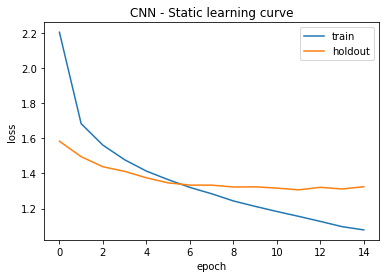

In [10]:
plt.plot(cnn_static_history.history['loss'], label='train')
plt.plot(cnn_static_history.history['val_loss'], label='holdout')
plt.title('CNN - Static learning curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [11]:
cnn_static.evaluate_generator(dataseq(X_test, y_test, batch_size))

[1.290729053490672, 0.6220171490941332, 0.8456586789304279]

**CNN - Dynamic**

In [12]:
layers = []

embedding_layer_dynamic1 = Embedding(num_words, embed_dim, embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length)(sequence_input1)

for sz in filters:
    conv_layer2 = Conv1D(filters=256, kernel_size=sz)(embedding_layer_dynamic1)
    batchnorm_layer2 = BatchNormalization()(conv_layer2)
    act_layer2 = Activation('relu')(batchnorm_layer2)
    pool_layer2 = GlobalMaxPool1D()(act_layer2)
    layers.append(pool_layer2)

merged2 = Concatenate(axis=1)(layers)

drop2 = Dropout(0.5)(merged2)
dense2 = Dense(512, activation='relu')(drop2)
out2 = Dense(num_classes, activation='softmax')(dense2)

cnn_dynamic = Model(sequence_input1, out2)

In [13]:
cnn_dynamic.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', top_3_acc])
cnn_dynamic_history = cnn_dynamic.fit_generator(dataseq(X_train, y_train, batch_size), epochs=5, verbose=2,
                              validation_data = dataseq(X_holdout, y_holdout, batch_size), shuffle=True)

Epoch 1/5
 - 22s - loss: 2.1081 - acc: 0.4573 - top_3_acc: 0.6657 - val_loss: 1.5004 - val_acc: 0.5835 - val_top_3_acc: 0.8022
Epoch 2/5
 - 19s - loss: 1.4704 - acc: 0.5868 - top_3_acc: 0.8071 - val_loss: 1.3608 - val_acc: 0.6124 - val_top_3_acc: 0.8325
Epoch 3/5
 - 20s - loss: 1.2477 - acc: 0.6385 - top_3_acc: 0.8521 - val_loss: 1.3015 - val_acc: 0.6273 - val_top_3_acc: 0.8424
Epoch 4/5
 - 19s - loss: 1.0696 - acc: 0.6821 - top_3_acc: 0.8846 - val_loss: 1.3028 - val_acc: 0.6302 - val_top_3_acc: 0.8425
Epoch 5/5
 - 19s - loss: 0.9139 - acc: 0.7232 - top_3_acc: 0.9098 - val_loss: 1.3309 - val_acc: 0.6291 - val_top_3_acc: 0.8420


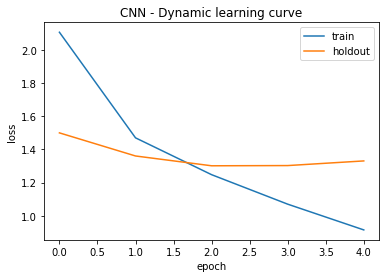

In [14]:
plt.plot(cnn_dynamic_history.history['loss'], label='train')
plt.plot(cnn_dynamic_history.history['val_loss'], label='holdout')
plt.title('CNN - Dynamic learning curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [15]:
cnn_dynamic.evaluate_generator(dataseq(X_test, y_test, batch_size))

[1.307106766630842, 0.6331564786927629, 0.8463124544902463]

**LSTM - Static**

In [16]:
sequence_input2 = Input(shape=(max_length, ), dtype='int32')
embedding_layer_static2 = Embedding(num_words, embed_dim, embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length, trainable=False)(sequence_input2)
lstm1 = CuDNNLSTM(500, return_sequences=True)(embedding_layer_static2)
drop3 = Dropout(0.5)(lstm1)
lstm2 = CuDNNLSTM(200)(drop3)
drop4 = Dropout(0.5)(lstm2)
out3 = Dense(num_classes, activation='softmax')(drop4)
lstm_static = Model(sequence_input2, out3)
lstm_static.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 200)           16268200  
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 50, 500)           1404000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 500)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 200)               561600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)                8040      
Total para

In [17]:
lstm_static.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', top_3_acc])
lstm_static_history = lstm_static.fit_generator(dataseq(X_train, y_train, batch_size, 'pre'), epochs=5, verbose=2,
                              validation_data = dataseq(X_holdout, y_holdout, batch_size, 'pre'))

Epoch 1/5
 - 28s - loss: 1.7480 - acc: 0.5339 - top_3_acc: 0.7477 - val_loss: 1.4539 - val_acc: 0.5964 - val_top_3_acc: 0.8127
Epoch 2/5
 - 26s - loss: 1.4052 - acc: 0.6093 - top_3_acc: 0.8229 - val_loss: 1.3266 - val_acc: 0.6205 - val_top_3_acc: 0.8366
Epoch 3/5
 - 26s - loss: 1.2727 - acc: 0.6398 - top_3_acc: 0.8494 - val_loss: 1.2700 - val_acc: 0.6343 - val_top_3_acc: 0.8498
Epoch 4/5
 - 27s - loss: 1.1665 - acc: 0.6658 - top_3_acc: 0.8686 - val_loss: 1.2562 - val_acc: 0.6407 - val_top_3_acc: 0.8522
Epoch 5/5
 - 26s - loss: 1.0699 - acc: 0.6891 - top_3_acc: 0.8853 - val_loss: 1.2732 - val_acc: 0.6403 - val_top_3_acc: 0.8507


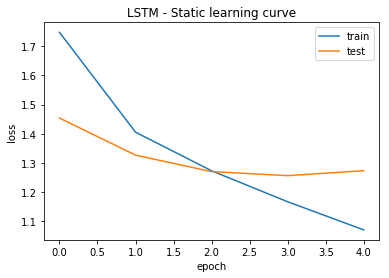

In [18]:
plt.plot(lstm_static_history.history['loss'], label='train')
plt.plot(lstm_static_history.history['val_loss'], label='test')
plt.title('LSTM - Static learning curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [19]:
lstm_static.evaluate_generator(dataseq(X_test, y_test, batch_size, 'pre'))

[1.2253644141691296, 0.6522919862848702, 0.8594885463851767]

**LSTM - Dynamic**

In [20]:
embedding_layer_dynamic2 = Embedding(num_words, embed_dim, embeddings_initializer=Constant(embedding_matrix),
                           input_length=max_length)(sequence_input2)
lstm3 = CuDNNLSTM(500, return_sequences=True)(embedding_layer_dynamic2)
drop5 = Dropout(0.5)(lstm3)
lstm4 = CuDNNLSTM(200)(drop5)
drop6 = Dropout(0.5)(lstm4)
out4 = Dense(num_classes, activation='softmax')(drop6)
lstm_dynamic = Model(sequence_input2, out4)

In [21]:
lstm_dynamic.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', top_3_acc])
lstm_dynamic_history = lstm_dynamic.fit_generator(dataseq(X_train, y_train, batch_size, 'pre'), epochs=4, verbose=2,
                              validation_data = dataseq(X_holdout, y_holdout, batch_size, 'pre'))

Epoch 1/4
 - 34s - loss: 1.6757 - acc: 0.5540 - top_3_acc: 0.7609 - val_loss: 1.3568 - val_acc: 0.6205 - val_top_3_acc: 0.8354
Epoch 2/4
 - 32s - loss: 1.2185 - acc: 0.6586 - top_3_acc: 0.8593 - val_loss: 1.2648 - val_acc: 0.6406 - val_top_3_acc: 0.8506
Epoch 3/4
 - 32s - loss: 0.9872 - acc: 0.7165 - top_3_acc: 0.8988 - val_loss: 1.2591 - val_acc: 0.6478 - val_top_3_acc: 0.8550
Epoch 4/4
 - 32s - loss: 0.7897 - acc: 0.7692 - top_3_acc: 0.9270 - val_loss: 1.3421 - val_acc: 0.6392 - val_top_3_acc: 0.8483


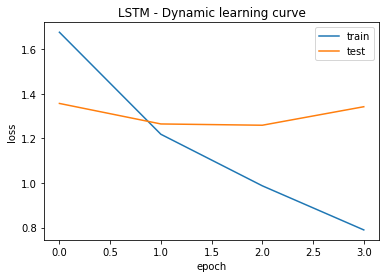

In [22]:
plt.plot(lstm_dynamic_history.history['loss'], label='train')
plt.plot(lstm_dynamic_history.history['val_loss'], label='test')
plt.title('LSTM - Dynamic learning curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [23]:
lstm_dynamic.evaluate_generator(dataseq(X_test, y_test, batch_size, 'pre'))

[1.3062808119014815, 0.6457290855030527, 0.8531268073661838]

**Ensemble**

In [24]:
models = [cnn_static, cnn_dynamic, lstm_static, lstm_dynamic]

for i in range(len(models)):
    for layer in models[i].layers:
        layer.trainable = False

input_layers = [sequence_input1, sequence_input2]
output_layers = [model.output for model in models]
ensemble_merge = Concatenate()(output_layers)
ensemble_dense = Dense(100, activation='relu')(ensemble_merge)
output = Dense(num_classes, activation='softmax')(ensemble_dense)
model = Model(inputs=input_layers, outputs=output)

In [25]:
class meta_dataseq(Sequence):
    def __init__(self, X, y, batch_size):
        self.x, self.y = X, y
        self.batch_size = batch_size
        self.m = len(self.y)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:min((idx + 1) * self.batch_size, self.m)]
        batch_y = to_categorical(self.y[idx * self.batch_size:min((idx + 1) * self.batch_size, self.m)],
                                 num_classes=num_classes)
        
        return [pad_sequences(batch_x, maxlen=max_length, truncating='post', padding='post'),
                 pad_sequences(batch_x, maxlen=max_length, truncating='post', padding='pre')], batch_y

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', top_3_acc])
model_history = model.fit_generator(meta_dataseq(X_holdout, y_holdout, batch_size), epochs=20, verbose=2,
                              validation_data = meta_dataseq(X_test, y_test, batch_size))

Epoch 1/20
 - 12s - loss: 2.3875 - acc: 0.5272 - top_3_acc: 0.6781 - val_loss: 1.5268 - val_acc: 0.6448 - val_top_3_acc: 0.8162
Epoch 2/20
 - 10s - loss: 1.4377 - acc: 0.6485 - top_3_acc: 0.8288 - val_loss: 1.3233 - val_acc: 0.6690 - val_top_3_acc: 0.8437
Epoch 3/20
 - 10s - loss: 1.3367 - acc: 0.6595 - top_3_acc: 0.8419 - val_loss: 1.2891 - val_acc: 0.6706 - val_top_3_acc: 0.8484
Epoch 4/20
 - 10s - loss: 1.3023 - acc: 0.6639 - top_3_acc: 0.8450 - val_loss: 1.2738 - val_acc: 0.6710 - val_top_3_acc: 0.8473
Epoch 5/20
 - 10s - loss: 1.2909 - acc: 0.6644 - top_3_acc: 0.8446 - val_loss: 1.2677 - val_acc: 0.6728 - val_top_3_acc: 0.8500
Epoch 6/20
 - 10s - loss: 1.2768 - acc: 0.6642 - top_3_acc: 0.8476 - val_loss: 1.2610 - val_acc: 0.6723 - val_top_3_acc: 0.8502
Epoch 7/20
 - 10s - loss: 1.2716 - acc: 0.6637 - top_3_acc: 0.8483 - val_loss: 1.2582 - val_acc: 0.6730 - val_top_3_acc: 0.8513
Epoch 8/20
 - 10s - loss: 1.2671 - acc: 0.6653 - top_3_acc: 0.8510 - val_loss: 1.2559 - val_acc: 0.6723 

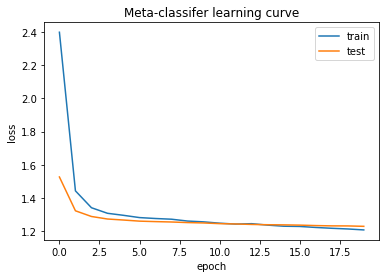

In [26]:
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.title('Meta-classifer learning curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [27]:
plot_model(model, to_file='model.png')
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5')
print('Saved model to disk')

Saved model to disk
